---

## **Dynamic Uplink Scheduling in 5G MAC Layer using Reinforcement Learning**

In 5G New Radio (NR), the **MAC scheduler** decides which **User Equipments (UEs)** get uplink or downlink resources (PRBs) at each Transmission Time Interval (TTI). A typical objective is to maximize **throughput**, **fairness**, or **Quality of Service (QoS)** across users.

Traditional scheduling algorithms (e.g., Proportional Fair, Round Robin) use fixed heuristics. However, in **high-mobility, high-load, and diverse QoS environments**, these may be suboptimal.

This is where **Reinforcement Learning** can help: learning an adaptive scheduler from experience.

### 2. **Environment Design (MDP Formulation)**

| Component         | Description                                                                                                    |                                                           |
| ----------------- | -------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------- |
| **State $s_t$**   | Buffer status reports (BSR), Channel Quality Indicators (CQI), HARQ feedback, UE priority/QoS, past throughput |                                                           |
| **Action $a_t$**  | Resource allocation decision: e.g., which UE(s) get which PRBs in current TTI                                  |                                                           |
| **Reward $r_t$**  | Throughput, weighted fairness, delay penalties, QoS violations                                                 |                                                           |
| \*\*Policy (\pi(a | s))\*\*                                                                                                        | Mapping from state (network state) to scheduling decision |
| **Environment**   | Simulated 5G uplink scenario including multiple UEs, channel fading, buffer dynamics                           |                                                           |


### 3. **Simple Example Setup**

#### Uplink RL Scheduler:

* **10 UEs** with different buffer sizes and CQI.
* **RL Agent** selects a UE every TTI (1 ms) to allocate full bandwidth.
* **Reward** is:

  $$
  r_t = \text{transmitted bits}_t - \lambda \cdot \text{delay}_t
  $$

  where delay penalizes old packets.


### 4. **Algorithm Choice**

* **Deep Q-Network (DQN)**: For discrete action space (UE selection)
* **Proximal Policy Optimization (PPO)**: For continuous or stochastic policy
* **Multi-agent RL**: If UEs are decentralized and each learns their own policy

### 5. **Implementation Tools**

* **Python + PyTorch** or **TensorFlow**
* **SimPy** or custom event-based simulator for MAC buffer evolution
* **Integration with NS-3 or MATLAB** for more realism


### 6. **Possible Extensions**

| Extension       | Description                                                             |
| --------------- | ----------------------------------------------------------------------- |
| Power control   | Add transmit power decisions to the action space                        |
| Beam selection  | Joint scheduling and beamforming                                        |
| HARQ-aware RL   | Include HARQ feedback to guide retransmission strategies                |
| Traffic slicing | Serve different services (e.g., URLLC vs eMBB) with adaptive priorities |


### 7. **Outcome**

With enough training, the RL scheduler **learns**:

* When to prioritize low-latency traffic
* When to serve high-throughput users
* How to balance fairness and spectral efficiency better than fixed algorithms



In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Basic setup
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI per UE
ACTION_SIZE = NUM_UES     # pick one UE per TTI
MAX_BUFFER = 1000
CQI_LEVELS = 16  # CQI index 1–15

# Simple environment
class UplinkEnv:
    def __init__(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi  # Simplified mapping
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)

        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_values = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


In [3]:
env = UplinkEnv()
agent = DQNAgent()

episodes = 300
for ep in range(episodes):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    print(f"Episode {ep+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


/var/folders/s3/38gpf0796ls5pl2z8c7czftr0000gn/T/ipykernel_71280/357467912.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  s = torch.FloatTensor(s)


Episode 1, Total Reward: 2322.00, Epsilon: 0.429
Episode 2, Total Reward: 2865.00, Epsilon: 0.157
Episode 3, Total Reward: 1781.00, Epsilon: 0.058
Episode 4, Total Reward: 2028.00, Epsilon: 0.021
Episode 5, Total Reward: 1380.00, Epsilon: 0.010
Episode 6, Total Reward: 2461.00, Epsilon: 0.010
Episode 7, Total Reward: 1419.00, Epsilon: 0.010
Episode 8, Total Reward: 1711.00, Epsilon: 0.010
Episode 9, Total Reward: 2417.00, Epsilon: 0.010
Episode 10, Total Reward: 2033.00, Epsilon: 0.010
Episode 11, Total Reward: 1883.00, Epsilon: 0.010
Episode 12, Total Reward: 3016.00, Epsilon: 0.010
Episode 13, Total Reward: 1937.00, Epsilon: 0.010
Episode 14, Total Reward: 1519.00, Epsilon: 0.010
Episode 15, Total Reward: 1432.00, Epsilon: 0.010
Episode 16, Total Reward: 2315.00, Epsilon: 0.010
Episode 17, Total Reward: 3211.00, Epsilon: 0.010
Episode 18, Total Reward: 2608.00, Epsilon: 0.010
Episode 19, Total Reward: 2919.00, Epsilon: 0.010
Episode 20, Total Reward: 2668.00, Epsilon: 0.010
Episode 2

---

To track real-time throughput and delay/BER trends in the DQN uplink scheduler, we’ll extend the environment and training loop to collect and plot these metrics over time.

Since we don’t simulate PHY-layer BER directly, we’ll track:

Throughput (bits transmitted per episode)

Average delay (of head-of-line packets)

Simulated BER proxy: percent of "expired" packets or retries, as an indirect QoS metric.




Episode 1, Reward: 2733.0, Throughput: 30.1 b/slot, Delay: 12.20, Epsilon: 0.43
Episode 2, Reward: 2966.0, Throughput: 29.1 b/slot, Delay: 20.13, Epsilon: 0.16
Episode 3, Reward: 3220.0, Throughput: 26.7 b/slot, Delay: 44.44, Epsilon: 0.06
Episode 4, Reward: 2258.0, Throughput: 18.0 b/slot, Delay: 59.13, Epsilon: 0.02
Episode 5, Reward: 3172.0, Throughput: 20.5 b/slot, Delay: 68.21, Epsilon: 0.01
Episode 6, Reward: 2389.0, Throughput: 19.8 b/slot, Delay: 62.60, Epsilon: 0.01
Episode 7, Reward: 2274.0, Throughput: 16.0 b/slot, Delay: 67.61, Epsilon: 0.01
Episode 8, Reward: 2483.0, Throughput: 22.0 b/slot, Delay: 61.38, Epsilon: 0.01
Episode 9, Reward: 1333.0, Throughput: 13.1 b/slot, Delay: 66.68, Epsilon: 0.01
Episode 10, Reward: 3286.0, Throughput: 25.5 b/slot, Delay: 54.41, Epsilon: 0.01
Episode 11, Reward: 1825.0, Throughput: 13.1 b/slot, Delay: 74.46, Epsilon: 0.01
Episode 12, Reward: 2316.0, Throughput: 15.2 b/slot, Delay: 72.31, Epsilon: 0.01
Episode 13, Reward: 2308.0, Throughpu

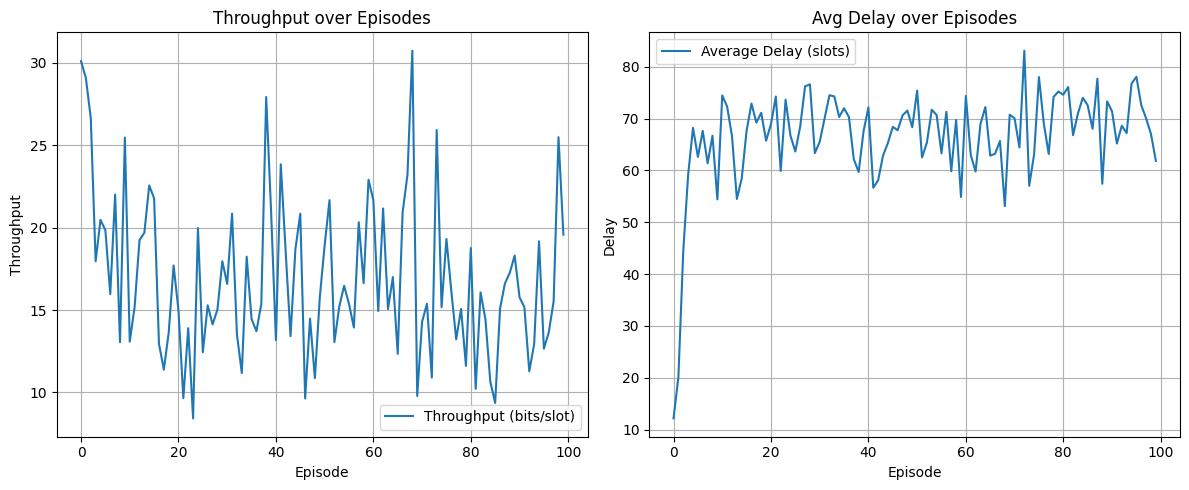

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Constants
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI
ACTION_SIZE = NUM_UES
MAX_BUFFER = 1000
CQI_LEVELS = 16
EPISODES = 100

# Environment
class UplinkEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.total_bits = 0
        self.total_delay = []
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits
        self.total_bits += tx_bits
        self.total_delay.append(np.mean(self.delay))

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done

# DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_vals = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_vals, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

# Instantiate
env = UplinkEnv()
agent = DQNAgent()

# Training Loop
episode_rewards = []
episode_throughput = []
episode_avg_delay = []

for ep in range(EPISODES):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    episode_rewards.append(total_reward)
    episode_throughput.append(env.total_bits / env.time)
    episode_avg_delay.append(np.mean(env.total_delay))
    print(f"Episode {ep+1}, Reward: {total_reward:.1f}, "
          f"Throughput: {episode_throughput[-1]:.1f} b/slot, "
          f"Delay: {episode_avg_delay[-1]:.2f}, Epsilon: {agent.epsilon:.2f}")

# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_throughput, label="Throughput (bits/slot)")
plt.xlabel("Episode")
plt.ylabel("Throughput")
plt.grid(True)
plt.title("Throughput over Episodes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(episode_avg_delay, label="Average Delay (slots)")
plt.xlabel("Episode")
plt.ylabel("Delay")
plt.grid(True)
plt.title("Avg Delay over Episodes")
plt.legend()

plt.tight_layout()
plt.show()
